In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd
from typing import Tuple


In [2]:
# 1. set file path
file_path = "../Laptimeoptimization/Monza.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

      # x_m        y_m  w_tr_right_m  w_tr_left_m
0 -0.320123   1.087714         5.739        5.932
1  0.168262   6.062191         5.735        5.929
2  0.656139  11.036647         5.731        5.926
3  1.143549  16.011082         5.727        5.923
4  1.630535  20.985493         5.723        5.920


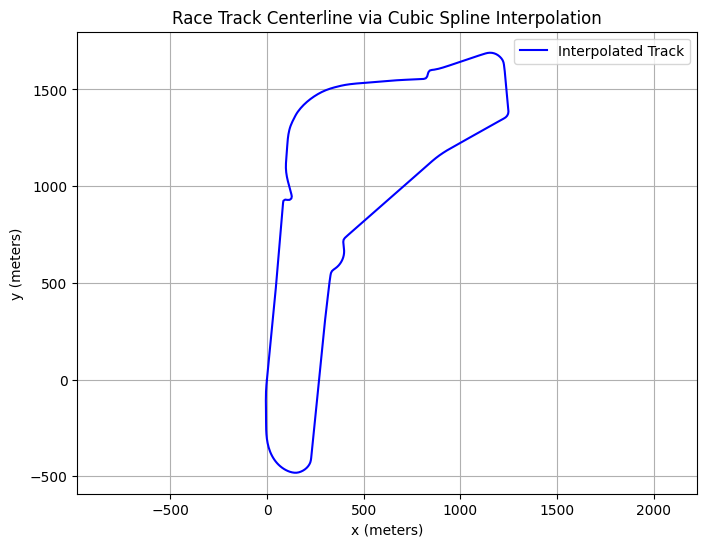

In [3]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

In [42]:
# ======================================================================
# ================= v3 FINAL DEBUG VERSION =============================
# ======================================================================

# ----------------------------------------------------------------------
# ============       PARAMETERS (easy to tune)        ==================
# ----------------------------------------------------------------------
ANG_MIN_DEG   = 5.0          # θ candidates below this are ignored      (°)
CURV_MIN      = 4e-4        # |κ| below this is considered "straight" (1/m)
SLIDING_WIN   = 0.0         # sliding-max window length along s (m)
DENSE_STEP    = 1.0          # dense sampling step for boundaries (m)
DELTA_S       = 200.0        # forward window for FOV (m)

# ============  Helper functions: REVISED AND CORRECTED  ==============
from typing import Tuple
import pandas as pd # Make sure pandas is imported

def build_boundaries(spline_x, spline_y,
                     w_left: np.ndarray, w_right: np.ndarray,
                     s_dense: np.ndarray
                     ) -> Tuple[
                         Tuple[np.ndarray, np.ndarray],   # left (x,y)
                         Tuple[np.ndarray, np.ndarray],   # right (x,y)
                     ]:
    """Return dense left/right boundary samples."""
    xc = spline_x(s_dense)
    yc = spline_y(s_dense)

    dx = spline_x.derivative(1)(s_dense)
    dy = spline_y.derivative(1)(s_dense)
    norm_t = np.hypot(dx, dy)
    tx, ty = dx / norm_t, dy / norm_t
    nx, ny = -ty, tx  # left normal

    w_left_d  = np.interp(s_dense, s, w_left)
    w_right_d = np.interp(s_dense, s, w_right)

    xl = xc + nx * w_left_d
    yl = yc + ny * w_left_d
    xr = xc - nx * w_right_d
    yr = yc - ny * w_right_d
    return (xl, yl), (xr, yr)

def first_crossing(s_start_search: float,
                   ray_origin: np.ndarray,
                   ray_direction: np.ndarray,
                   line_x: np.ndarray,
                   line_y: np.ndarray,
                   line_s_coords: np.ndarray) -> float:
    """
    Finds the first intersection of a ray with a line strip.
    This version is self-contained and does not depend on any global variables.
    """
    i0 = np.searchsorted(line_s_coords, s_start_search, side='left')
    start_index = i0 + 1

    if start_index >= len(line_x) - 1:
        return np.inf

    for i in range(start_index, len(line_x) - 1):
        A = np.array([line_x[i], line_y[i]])
        B = np.array([line_x[i + 1], line_y[i + 1]])
        v = B - A
        
        if abs(ray_direction[0] * v[1] - ray_direction[1] * v[0]) < 1e-9:
            continue

        M = np.column_stack((ray_direction, -v))
        rhs = A - ray_origin
        try:
            t, u = np.linalg.solve(M, rhs)
        except np.linalg.LinAlgError:
            continue
            
        if t > 1e-6 and 0.0 <= u <= 1.0:
            return line_s_coords[i] + u * (line_s_coords[i + 1] - line_s_coords[i])
            
    return np.inf

""" def has_local_extreme(theta: np.ndarray) -> bool:
    #Checks for non-monotonic behavior in the angle sequence.
    if len(theta) < 3:
        return False
    diffs = np.diff(theta)
    significant_diffs = diffs[np.abs(diffs) > 1e-5]
    if len(significant_diffs) < 2:
        return False
    signs = np.sign(significant_diffs)
    return np.any(signs[:-1] != signs[1:]) """
def has_local_extreme(theta):
    # 大幅放宽条件，只要有变化就算极值
    if len(theta) < 3:
        return False
    diffs = np.diff(theta)
    signs = np.sign(diffs)
    return np.any(signs[:-1] != signs[1:])

""" def debug_plot_fov(s0, s0_pos, dir_vec, window_data, tangent_info_L, tangent_info_R):
    # A powerful debugging function to visualize the geometry at a single point s0.
    s_win, xl_win, yl_win, xr_win, yr_win = window_data
    p_t_L, s_t_L, _, _ = tangent_info_L
    p_t_R, s_t_R, _, _ = tangent_info_R

    plt.figure(figsize=(12, 10))
    
    plt.plot(xl_win, yl_win, 'b-', label='Left Boundary in Window')
    plt.plot(xr_win, yr_win, 'r-', label='Right Boundary in Window')
    plt.plot(s0_pos[0], s0_pos[1], 'ko', markersize=10, label=f'Car at s={s0:.1f}')
    plt.arrow(s0_pos[0], s0_pos[1], dir_vec[0] * 50, dir_vec[1] * 50, 
              color='k', width=1, head_width=5, label='Car Direction')

    if p_t_L is not None:
        plt.plot(p_t_L[0], p_t_L[1], 'c*', markersize=15, label=f'Left Tangent Point (s={s_t_L:.1f})')
        plt.plot([s0_pos[0], p_t_L[0]], [s0_pos[1], p_t_L[1]], 'c--', label='View to Left Tangent')
    if p_t_R is not None:
        plt.plot(p_t_R[0], p_t_R[1], 'm*', markersize=15, label=f'Right Tangent Point (s={s_t_R:.1f})')
        plt.plot([s0_pos[0], p_t_R[0]], [s0_pos[1], p_t_R[1]], 'm--', label='View to Right Tangent')
        
    plt.axis('equal')
    plt.title(f'FOV Geometry Debug at s = {s0:.1f}')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    plt.grid(True)
    plt.show() """

def compute_fov_all(spline_x, spline_y,
                    w_left: np.ndarray, w_right: np.ndarray,
                    s_query: np.ndarray,
                    delta_s: float = DELTA_S,
                    step: float = DENSE_STEP,
                    debug_s: float = None): # Added debug_s parameter
    """Compute sfov(s) for every point in s_query with a debug hook."""
    s_dense = np.arange(0, s_max + step, step)
    (xl, yl), (xr, yr) = build_boundaries(spline_x, spline_y, w_left, w_right, s_dense)
    sfov_raw = np.empty_like(s_query)

    for k, s0 in enumerate(s_query):
        s0_pos = np.array([spline_x(s0), spline_y(s0)])
        tx0 = spline_x.derivative(1)(s0)
        ty0 = spline_y.derivative(1)(s0)
        dir_vec = np.array([tx0, ty0]) / np.hypot(tx0, ty0)
        
        idx0 = np.searchsorted(s_dense, s0)
        idx_w = np.searchsorted(s_dense, s0 + delta_s, side='right')
        
        s_win, xl_win, yl_win, xr_win, yr_win = s_dense, xl, yl, xr, yr
        if idx_w >= len(s_dense):
            extra = idx_w - len(s_dense) + 2
            s_win = np.concatenate((s_dense, s_dense[1:extra] + s_max))
            xl_win = np.concatenate((xl, xl[1:extra]))
            yl_win = np.concatenate((yl, yl[1:extra]))
            xr_win = np.concatenate((xr, xr[1:extra]))
            yr_win = np.concatenate((yr, yr[1:extra]))

        """ def get_tangent_info(xb, yb, find_max):
            Vx = xb[idx0:idx_w] - s0_pos[0]
            Vy = yb[idx0:idx_w] - s0_pos[1]
            dist_sq = Vx**2 + Vy**2
            mask = dist_sq > 1.0
            if not np.any(mask): 
                return None, None, None, False
            Vx_m, Vy_m = Vx[mask], Vy[mask]
            s_win_m = s_win[idx0:idx_w][mask]
            xb_m, yb_m = xb[idx0:idx_w][mask], yb[idx0:idx_w][mask]
            cross = dir_vec[0] * Vy_m - dir_vec[1] * Vx_m
            dot   = dir_vec[0] * Vx_m + dir_vec[1] * Vy_m
            theta = np.arctan2(cross, dot) """
        
        """ def get_tangent_info(xb, yb, find_max):
            Vx = xb[idx0:idx_w] - s0_pos[0]
            Vy = yb[idx0:idx_w] - s0_pos[1]
            if not np.any((Vx**2 + Vy**2) > 1.0):
                return None, None, None, False

            cross = dir_vec[0]*Vy - dir_vec[1]*Vx
            dot   = dir_vec[0]*Vx + dir_vec[1]*Vy
            theta = np.arctan2(cross, dot)

            # ------- 只改下面两行 ---------
            idx_extreme = np.argmax(theta) if find_max else np.argmin(theta)
            # 保证至少有一个点被选为切点，无需 has_local_extreme
            # --------------------------------

            p_tangent = np.array([xb[idx0:idx_w][idx_extreme],
                                yb[idx0:idx_w][idx_extreme]])
            s_tangent = s_win[idx0:idx_w][idx_extreme]
            ray_dir   = p_tangent - s0_pos
            ray_dir  /= np.linalg.norm(ray_dir)
            return p_tangent, s_tangent, ray_dir, True



            if not has_local_extreme(theta):
                return None, None, None, False
            if len(theta) == 0:
                return None, None, None, False
            

            
            if find_max:
                idx_extreme = np.argmax(theta)
            else:
                idx_extreme = np.argmin(theta)
            p_tangent = np.array([xb_m[idx_extreme], yb_m[idx_extreme]])
            s_tangent = s_win_m[idx_extreme]
            ray_dir = p_tangent - s0_pos
            ray_dir /= np.linalg.norm(ray_dir)
            return p_tangent, s_tangent, ray_dir, True """
        

        """ def get_tangent_info(xb, yb, find_max):
            
            #Always return a tangent: the point that gives the
            #maximal (or minimal) bearing angle θ within the window.
            
            Vx = xb[idx0:idx_w] - s0_pos[0]
            Vy = yb[idx0:idx_w] - s0_pos[1]

            # 如果窗口里距离太近直接放弃
            valid = (Vx*Vx + Vy*Vy) > 1.0
            if not np.any(valid):
                return None, None, None, False

            Vx, Vy = Vx[valid], Vy[valid]
            s_win_sub = s_win[idx0:idx_w][valid]

            cross = dir_vec[0] * Vy - dir_vec[1] * Vx
            dot   = dir_vec[0] * Vx + dir_vec[1] * Vy
            theta = np.arctan2(cross, dot)

            # ------------- 核心两行 -------------
            idx_ext = np.argmax(theta) if find_max else np.argmin(theta)
            # ------------------------------------

            p_tan   = np.array([xb[idx0:idx_w][valid][idx_ext],
                                yb[idx0:idx_w][valid][idx_ext]])
            s_tan   = s_win_sub[idx_ext]
            ray_dir = p_tan - s0_pos
            ray_dir = ray_dir / np.linalg.norm(ray_dir)
            return p_tan, s_tan, ray_dir, True """
        


        def get_tangent_info_improved(xb, yb, s_dense, s0, s0_pos, dir_vec,
                              find_max, ANG_MIN_RAD=np.deg2rad(ANG_MIN_DEG)):
            # ---------- 计算相对向量 ----------
            Vx = xb - s0_pos[0]
            Vy = yb - s0_pos[1]

            # 只保留前方 & 距离>1m 的点
            dot   = dir_vec[0]*Vx + dir_vec[1]*Vy
            valid = (Vx**2 + Vy**2 > 1.0) & (dot > 1e-3)
            if not np.any(valid):
                return None, None, None, False

            Vx, Vy, dot, s_win_sub = Vx[valid], Vy[valid], dot[valid], s_dense[valid]
            cross  = dir_vec[0]*Vy - dir_vec[1]*Vx
            theta  = np.arctan2(cross, dot)

            idx_ext = np.argmax(theta) if find_max else np.argmin(theta)
            p_tan   = np.array([xb[valid][idx_ext], yb[valid][idx_ext]])
            s_tan   = s_win_sub[idx_ext]
            ray_dir = p_tan - s0_pos
            ray_dir /= np.linalg.norm(ray_dir)
            return p_tan, s_tan, ray_dir, True
        




        
        # --- Main logic with debug hook ---
        kappa_now = (spline_x.derivative(1)(s0) * spline_y.derivative(2)(s0)
                     - spline_y.derivative(1)(s0) * spline_x.derivative(2)(s0))

        """ p_t_R, s_t_R, ray_R, has_ext_R = get_tangent_info_improved(xr_win, yr_win, find_max=False)
        p_t_L, s_t_L, ray_L, has_ext_L = get_tangent_info_improved(xl_win, yl_win, find_max=True) """

        p_t_R, s_t_R, ray_R, has_ext_R = get_tangent_info_improved(
            xr_win[idx0:idx_w], yr_win[idx0:idx_w], s_win[idx0:idx_w],
            s0, s0_pos, dir_vec, find_max=False)

        p_t_L, s_t_L, ray_L, has_ext_L = get_tangent_info_improved(
            xl_win[idx0:idx_w], yl_win[idx0:idx_w], s_win[idx0:idx_w],
            s0, s0_pos, dir_vec, find_max=True)

        if debug_s is not None and abs(s0 - debug_s) < (s_query[1]-s_query[0])/2:
            print(f"--- DEBUGGING AT s0 = {s0:.2f} ---")
            print(f"Kappa = {kappa_now:.4f}")
            if has_ext_L: print(f"Left Tangent: s={s_t_L:.2f}, pos=({p_t_L[0]:.2f}, {p_t_L[1]:.2f})")
            else: print("Left Tangent: Not found.")
            if has_ext_R: print(f"Right Tangent: s={s_t_R:.2f}, pos=({p_t_R[0]:.2f}, {p_t_R[1]:.2f})")
            else: print("Right Tangent: Not found.")
            window_data = (s_win[idx0:idx_w], xl_win[idx0:idx_w], yl_win[idx0:idx_w], xr_win[idx0:idx_w], yr_win[idx0:idx_w])
            tangent_info_L = (p_t_L, s_t_L, ray_L, has_ext_L)
            tangent_info_R = (p_t_R, s_t_R, ray_R, has_ext_R)
            debug_plot_fov(s0, s0_pos, dir_vec, window_data, tangent_info_L, tangent_info_R)
        
        s_inner = np.inf
        s_outer = np.inf
        
        if abs(kappa_now) < CURV_MIN:
            sfov_raw[k] = s0 + delta_s
            continue


        # --- THIS IS THE NEW LOGIC ---
        s_lim_L = np.inf
        s_lim_R = np.inf

        # --- Ray casting for the LEFT boundary ---
        # We always find the tangent point on the left boundary...
        #p_t_L, s_t_L, ray_L, has_ext_L = get_tangent_info_improved(xl_win, yl_win, find_max=True)
        if has_ext_L:
            # ... and check if this view is blocked by the RIGHT (opposite) boundary.
            s_lim_L = first_crossing(s_t_L, p_t_L, ray_L, xr_win, yr_win, s_win)
            
        # --- Ray casting for the RIGHT boundary ---
        # We always find the tangent point on the right boundary...
        #p_t_R, s_t_R, ray_R, has_ext_R = get_tangent_info_improved(xr_win, yr_win, find_max=False)
        if has_ext_R:
            # ... and check if this view is blocked by the LEFT (opposite) boundary.
            s_lim_R = first_crossing(s_t_R, p_t_R, ray_R, xl_win, yl_win, s_win)

        # The final FOV is the minimum of the two possible occlusions, or the max look-ahead.
        sfov_raw[k] = min(s_lim_L, s_lim_R, s0 + delta_s)

        """ if kappa_now < 0:
            if has_ext_R: s_inner = first_crossing(s_t_R, p_t_R, ray_R, xr_win, yr_win, s_win)
            if has_ext_L: s_outer = first_crossing(s_t_L, p_t_L, ray_L, xl_win, yl_win, s_win)
        else:
            if has_ext_L: s_inner = first_crossing(s_t_L, p_t_L, ray_L, xl_win, yl_win, s_win)
            if has_ext_R: s_outer = first_crossing(s_t_R, p_t_R, ray_R, xr_win, yr_win, s_win)

        if s_inner == np.inf and s_outer == np.inf:
            sfov_raw[k] = s0 + delta_s
        else:
            sfov_raw[k] = min(s_inner, s_outer, s0 + delta_s) """
    
    win_samples = int(SLIDING_WIN / (s_query[1] - s_query[0])) if len(s_query) > 1 else 1
    sfov_series = pd.Series(sfov_raw)
    sfov_filt = sfov_series.rolling(window=win_samples, min_periods=1).max().to_numpy()
    return sfov_raw, sfov_filt




dbg_s0 = 1159.4      # ← 选你打印曲率觉得有大弯的任意 s 值


def compute_fov_simple(
        spline_x, spline_y,
        w_left, w_right,
        s_query,
        delta_s       = 200,   # search window length [m] – we look for tangent points
                           # in the range  s0 … s0 + delta_s.  Increase (→300-400 m)
                           # if you have very large-radius corners.

    dense_step    = 0.5,   # resampling step for track boundaries [m].
                           # Finer → smoother θ-curve but heavier computation.

    ang_min_deg   = 4,     # minimum total bearing span (θ.ptp) [deg] that qualifies
                           # as a “curved” segment.  If θ.ptp < ang_min_deg we treat
                           # the segment as straight and simply set sfov = s + delta_s.

    peak_min_deg  = 0,     # peak-gap threshold [deg] used to filter out
                           # ultra-flat “pseudo peaks”.  0 = no filtering;
                           # in production 0.5–2 deg is typical.

    min_dist      = 5,     # minimum distance from car to candidate point [m].
                           # Suppresses tangent points that are too close
                           # (numerical noise or inside track width).

    min_arc       = 10,    # minimum arc-length (s_tan − s0) [m] before a point
                           # can be accepted as tangent; prevents 1–2 m “false hits”.

    curv_min      = 1e-5   # curvature threshold – below this |κ| the centreline
                           # is considered straight, skipping tangent search.
):


    s_dense = np.arange(0, s_max + dense_step, dense_step)
    (xl, yl), (xr, yr) = build_boundaries(spline_x, spline_y,
                                          w_left, w_right, s_dense)

    sfov = np.empty_like(s_query)
    ang_min  = np.deg2rad(ang_min_deg)
    peak_min = np.deg2rad(peak_min_deg)

    # ---------------- 主循环 ----------------
    for k, s0 in enumerate(s_query):

        # 车辆位置 + 朝向
        p_car = np.array([spline_x(s0), spline_y(s0)])
        t     = np.array([spline_x.derivative(1)(s0),
                          spline_y.derivative(1)(s0)])
        dir_v = t / np.linalg.norm(t)

        # 直线段直接给最大 FOV
        kappa_now = (spline_x.derivative(1)(s0)*spline_y.derivative(2)(s0)
                     - spline_y.derivative(1)(s0)*spline_x.derivative(2)(s0))
        if abs(kappa_now) < curv_min:
            sfov[k] = s0 + delta_s
            continue

        idx0 = np.searchsorted(s_dense, s0)
        idx1 = np.searchsorted(s_dense, s0 + delta_s, side="right")
        s_win = s_dense[idx0:idx1]

        # ----------- 局部极值检测工具 -----------
        # ───── 把原来的 pick_extreme_local 整块替换为下面版本 ─────
        def pick_extreme_local(xb, yb, want_max):
            Vx = xb[idx0:idx1] - p_car[0]
            Vy = yb[idx0:idx1] - p_car[1]
            dist = np.hypot(Vx, Vy)
            dot  = dir_v[0]*Vx + dir_v[1]*Vy

            mask = (dist > min_dist) & (dot > 0)
            if not np.any(mask):
                return np.inf

            Vx, Vy, dot, s_seg = Vx[mask], Vy[mask], dot[mask], s_win[mask]
            theta = np.arctan2(dir_v[0]*Vy - dir_v[1]*Vx, dot)

            # ── 调试：始终打印一次 θ.ptp 及翻转数 ──
            if abs(s0 - dbg_s0) < dense_step/2:
                flips = np.where(np.sign(np.diff(theta))[:-1] *
                                np.sign(np.diff(theta))[1:] < 0)[0] + 1
                print(f"[dbg] s0={s0:.1f} θ.ptp={np.ptp(theta)*180/np.pi:5.2f}° "
                    f"flips={flips.size}")
            # ─────────────────────────────────────────

            # 1) 先找局部极值（符号翻转）
            dtheta = np.diff(theta)
            sign   = np.sign(dtheta)
            flips  = np.where(sign[:-1] * sign[1:] < 0)[0] + 1

            if flips.size:                       # A. 有翻转 → 用局部极值
                cand_idx = flips
            else:                                # B. 单调 → 用全局极值
                cand_idx = [np.argmax(theta)] if want_max else [np.argmin(theta)]

            # 2) 过滤尖峰
            peak_min = peak_min_deg * np.pi/180.0
            good = []
            for idx in cand_idx:
                left_gap  = abs(theta[idx] - theta[max(idx-1, 0)])
                right_gap = abs(theta[idx] - theta[min(idx+1, len(theta)-1)])
                if max(left_gap, right_gap) >= peak_min:
                    good.append(idx)
            if not good:
                return np.inf

            idx_sel = max(good, key=lambda i: theta[i]) if want_max else min(good, key=lambda i: theta[i])
            s_tan   = s_seg[idx_sel]

            # 3) 距离阈值
            if s_tan - s0 < min_arc:
                return np.inf

            # －－ 可选再打印一次最终筛选结果 －－
            if abs(s0 - dbg_s0) < dense_step/2:
                print(f"     arc={s_tan-s0:5.1f} m  gap={max(left_gap,right_gap)*180/np.pi:4.2f}°")

            return s_tan
        # ─────────────────────────────────────────────────────────────

        # 左右切点
        s_L = pick_extreme_local(xl, yl, want_max=True)   # 左边找最大 θ
        s_R = pick_extreme_local(xr, yr, want_max=False)  # 右边找最小 θ
        sfov[k] = min(s_L, s_R, s0 + delta_s)

    return sfov

In [43]:
'''
sfov_vals = compute_fov_all(
    x_spline, y_spline, w_left, w_right,
    s_query, delta_s=DELTA_S)

sfov_ca = ca.interpolant('sfov', 'linear', [s_query], sfov_vals)
'''
# === CORRECTED CODE ===

# # 1. Call the function and receive BOTH return values into two separate variables
# sfov_raw_vals, sfov_filtered_vals = compute_fov_simple(
#     x_spline, y_spline, w_left, w_right,
#     s_query, delta_s=DELTA_S
# )

# 1. 只接收一个返回值
sfov_vals = compute_fov_simple(
    x_spline, y_spline, w_left, w_right,
    s_query, delta_s=DELTA_S
)

# 2. CasADi 插值器
sfov_ca = ca.interpolant('sfov', 'linear', [s_query], sfov_vals)

# # 3. 保存 / 可视化
# _ = save_sfov_csv(s_query, sfov_vals, file_path)

# # 2. Use the FILTERED values to create the CasADi interpolant
# #    sfov_filtered_vals is the clean, single array that CasADi expects.
# sfov_ca = ca.interpolant('sfov', 'linear', [s_query], sfov_filtered_vals)

# # Now you can proceed with saving to CSV and visualization using both arrays.
# # For example, saving the final, clean data:
# _ = save_sfov_csv(s_query, sfov_filtered_vals, file_path)

[dbg] s0=1159.4 θ.ptp=74.13° flips=0
[dbg] s0=1159.4 θ.ptp=49.88° flips=1
     arc=126.6 m  gap=0.00°


In [44]:
# ---------- save_fov_to_csv.py ----------
import os
import pandas as pd

def save_sfov_csv(s_samples, sfov_samples,
                  in_csv_path: str,
                  out_name: str = "sfov_lookup.csv") -> str:
    """
    Save (s, sfov) pairs to a CSV file in the same folder as the input track.

    Parameters
    ----------
    s_samples     : 1-D array-like, arc-length samples.
    sfov_samples  : 1-D array-like, corresponding look-ahead values.
    in_csv_path   : str, path of the original track CSV (e.g. 'Monza.csv').
    out_name      : str, filename for the lookup table (default 'sfov_lookup.csv').

    Returns
    -------
    full_path     : str, absolute path of the written CSV file.
    """
    # build DataFrame
    df_out = pd.DataFrame({
        "s_m"   : s_samples,
        "sfov_m": sfov_samples
    })

    # decide output directory = same folder as input file
    out_dir = os.path.dirname(os.path.abspath(in_csv_path))
    full_path = os.path.join(out_dir, out_name)

    # write CSV (no index column)
    df_out.to_csv(full_path, index=False)
    print(f"[INFO] sfov table saved to: {full_path}")

    return full_path


# === example call ===
_ = save_sfov_csv(s_query, sfov_vals, file_path)

[INFO] sfov table saved to: /Users/yanxing.chen/SafeDrive25SS/Laptimeoptimization/sfov_lookup.csv


In [29]:
for s0 in s_query[::10]:        # 每隔 50 个点看看
    kappa = (x_spline.derivative(1)(s0) * y_spline.derivative(2)(s0)
             - y_spline.derivative(1)(s0) * x_spline.derivative(2)(s0))
    print(f"s={s0:6.1f}, |κ|={abs(kappa):.2e}")

s=   0.0, |κ|=2.18e-05
s= 115.9, |κ|=1.70e-05
s= 231.9, |κ|=4.78e-06
s= 347.8, |κ|=7.50e-05
s= 463.7, |κ|=5.31e-05
s= 579.7, |κ|=1.70e-05
s= 695.6, |κ|=1.92e-05
s= 811.6, |κ|=1.39e-05
s= 927.5, |κ|=8.36e-02
s=1043.4, |κ|=5.51e-04
s=1159.4, |κ|=2.18e-03
s=1275.3, |κ|=1.44e-03
s=1391.2, |κ|=1.36e-03
s=1507.2, |κ|=2.94e-03
s=1623.1, |κ|=3.31e-03
s=1739.0, |κ|=1.76e-03
s=1855.0, |κ|=4.16e-05
s=1970.9, |κ|=4.04e-04
s=2086.8, |κ|=1.10e-04
s=2202.8, |κ|=5.39e-03
s=2318.7, |κ|=1.77e-04
s=2434.7, |κ|=2.15e-04
s=2550.6, |κ|=1.35e-02
s=2666.5, |κ|=5.84e-04
s=2782.5, |κ|=2.02e-04
s=2898.4, |κ|=2.22e-02
s=3014.3, |κ|=5.36e-06
s=3130.3, |κ|=8.64e-05
s=3246.2, |κ|=1.22e-03
s=3362.1, |κ|=5.76e-04
s=3478.1, |κ|=2.83e-05
s=3594.0, |κ|=7.52e-06
s=3710.0, |κ|=5.11e-06
s=3825.9, |κ|=1.27e-05
s=3941.8, |κ|=1.70e-02
s=4057.8, |κ|=8.91e-03
s=4173.7, |κ|=1.02e-03
s=4289.6, |κ|=3.36e-05
s=4405.6, |κ|=1.34e-04
s=4521.5, |κ|=2.96e-05
s=4637.4, |κ|=7.11e-06
s=4753.4, |κ|=7.46e-06
s=4869.3, |κ|=4.02e-06
s=4985.2, |

In [41]:
# 只给一个 s_query，调试信息会更清晰
test_s = np.array([dbg_s0])
sfov_dbg = compute_fov_simple(
    x_spline, y_spline, w_left, w_right,
    test_s,
    delta_s       = 200,
    dense_step    = 0.5,
    ang_min_deg   = 4,
    peak_min_deg  = 0,
    min_dist      = 5,
    min_arc       = 10,
    curv_min      = 1e-5
)
print("sfov_dbg =", sfov_dbg)

[dbg] s0=1159.4 θ.ptp=74.57° flips=0
[dbg] s0=1159.4 θ.ptp=50.24° flips=1
     arc=126.6 m  gap=0.00°
sfov_dbg = [1286.]


In [30]:
dbg_s0 = 1159.4         # κ ≈ 2.2e-3 的大弯中心
print("—— debug at s =", dbg_s0)
_ = compute_fov_simple(x_spline, y_spline, w_left, w_right,
                       np.array([dbg_s0]),   # 只跑一个点
                       delta_s=200, dense_step=0.5,
                       ang_min_deg=4, peak_min_deg=2,
                       min_dist=5, min_arc=20, curv_min=1e-5)
# 在 pick_extreme_local 里（临时）加几行：
#   print("theta.ptp=", theta.ptp()*180/π, "°",
#         "best_gap=", max(left_gap, right_gap)*180/π, "°",
#         "arc_len=", s_tan - s0)

—— debug at s = 1159.4


In [22]:
# ---------- sfov_interpolant.py ----------
from typing import Union, Callable
import numpy as np
from scipy.interpolate import CubicSpline

def build_sfov_interpolant(s_nodes: np.ndarray,
                           sfov_nodes: np.ndarray,
                           extrapolate: bool = True
                           ) -> Callable[[Union[float, np.ndarray]], np.ndarray]:
    """
    Create a C²-continuous cubic-spline interpolant sfov(s).

    Parameters
    ----------
    s_nodes     : 1-D ndarray, strictly increasing arc-length samples.
    sfov_nodes  : 1-D ndarray, same length, sfov at each sample.
    extrapolate : bool, default True, allow evaluation outside domain.

    Returns
    -------
    sfov_fun    : callable, use like  sfov_fun(s_eval)  →  sfov value(s).
    """
    # Natural BC: second derivative = 0 at both ends
    cs = CubicSpline(s_nodes, sfov_nodes,
                     bc_type="natural",
                     extrapolate=extrapolate)

    def sfov_fun(s_eval: Union[float, np.ndarray]) -> np.ndarray:
        """Vectorised wrapper around CubicSpline."""
        return cs(s_eval)

    return sfov_fun


# === example call & usage ===
sfov_fun = build_sfov_interpolant(s_query, sfov_vals)
print("sfov(123.4 m) =", float(sfov_fun(123.4)))

sfov(123.4 m) = 323.4


/var/folders/vw/l13tv5w120q5q88yj8hvhx4r0000gn/T/ipykernel_50755/48030074.py:51: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  car_dot.set_data(cx, cy)
/var/folders/vw/l13tv5w120q5q88yj8hvhx4r0000gn/T/ipykernel_50755/48030074.py:52: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  fov_dot.set_data(fx, fy)


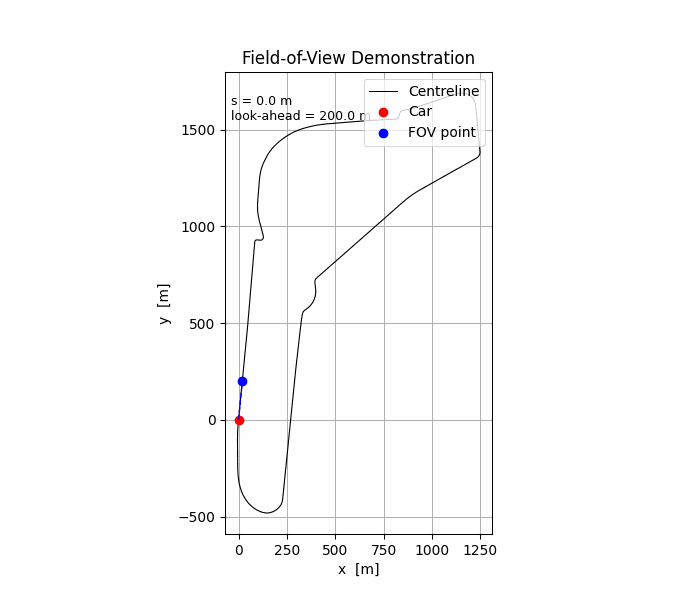

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

# --------------------------------------------------------------
# sanity-check that required objects are in scope
for _name in ["x_spline", "y_spline", "sfov_fun", "s_max"]:
    if _name not in globals():
        raise RuntimeError(f"Define {_name} before running the animation cell")

# 1. pre-compute background
s_bg = np.linspace(0.0, s_max, 1200)
x_bg = x_spline(s_bg)
y_bg = y_spline(s_bg)

# 2. choose sample frames
n_frames = 400                       # 400 frames ≈ 20 s at 20 fps
s_frames = np.linspace(0.0, s_max, n_frames, endpoint=False)

car_xy  = np.column_stack((x_spline(s_frames),          y_spline(s_frames)))
fov_s   = sfov_fun(s_frames)
fov_xy  = np.column_stack((x_spline(fov_s),             y_spline(fov_s)))
look_ahead = fov_s - s_frames

# 3. build static figure
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(x_bg, y_bg, lw=0.8, color='k', label='Centreline')
car_dot, = ax.plot([], [], 'ro', ms=6, label='Car')
fov_dot, = ax.plot([], [], 'bo', ms=6, label='FOV point')
look_line, = ax.plot([], [], 'b--', lw=1.0)
txt = ax.text(0.02, 0.95, '', transform=ax.transAxes,
              fontsize=9, va='top')
ax.set_aspect('equal')
ax.set_title("Field-of-View Demonstration")
ax.legend(loc='upper right')
ax.set_xlabel('x  [m]')
ax.set_ylabel('y  [m]')
ax.grid(True)

def init():
    car_dot.set_data([], [])
    fov_dot.set_data([], [])
    look_line.set_data([], [])
    txt.set_text('')
    return car_dot, fov_dot, look_line, txt

def update(i):
    cx, cy = car_xy[i]
    fx, fy = fov_xy[i]
    car_dot.set_data(cx, cy)
    fov_dot.set_data(fx, fy)
    look_line.set_data([cx, fx], [cy, fy])
    txt.set_text(f's = {s_frames[i]:.1f} m\n'
                 f'look-ahead = {look_ahead[i]:.1f} m')
    return car_dot, fov_dot, look_line, txt

anim = FuncAnimation(fig, update, frames=n_frames,
                     init_func=init, blit=True, interval=50)

# 4. save as GIF and display
gif_path = "fov_demo.gif"
anim.save(gif_path, writer=PillowWriter(fps=20))
plt.close(fig)        # prevent duplicate static image

display(Image(filename=gif_path))

In [9]:
dbg = sfov_vals - s_query
idx = np.where(dbg < 2.0)[0]          # 找出 look-ahead < 2 m 的样本
print("suspect s =", s_query[idx])

suspect s = [ 939.08111704  950.67471108  962.26830512  973.86189916  985.45549319
  997.04908723 1008.64268127 1020.23627531 1055.01705742 1066.61065146
 1078.20424549 1089.79783953 1101.39143357 1112.98502761 1124.57862164
 1136.17221568 1147.76580972 1159.35940376 1170.95299779 1182.54659183
 1228.92096798 1275.29534413 1286.88893817 1298.48253221 1310.07612625
 1321.66972028 1333.26331432 1344.85690836 1356.4505024  1368.04409643
 1379.63769047 1391.23128451 1426.01206662 1437.60566066 1449.1992547
 1460.79284873 1472.38644277 1483.98003681 1495.57363085 1507.16722488
 1518.76081892 1530.35441296 1541.948007   1553.54160103 1565.13519507
 1576.72878911 1588.32238315 1599.91597718 1611.50957122 1623.10316526
 1634.6967593  1646.29035334 1657.88394737 1669.47754141 1681.07113545
 1692.66472949 1704.25832352 1715.85191756 1727.4455116  1739.03910564
 1750.63269967 1762.22629371 1994.09817446 2005.6917685  2121.62770888
 2133.22130291 2144.81489695 2156.40849099 2168.00208503 2179.5956

suspect s: [ 939.08111704  950.67471108  962.26830512  973.86189916  985.45549319
  997.04908723 1008.64268127 1020.23627531 1055.01705742 1066.61065146
 1078.20424549 1089.79783953 1101.39143357 1112.98502761 1124.57862164
 1136.17221568 1147.76580972 1159.35940376 1170.95299779 1182.54659183
 1228.92096798 1275.29534413 1286.88893817 1298.48253221 1310.07612625
 1321.66972028 1333.26331432 1344.85690836 1356.4505024  1368.04409643
 1379.63769047 1391.23128451 1426.01206662 1437.60566066 1449.1992547
 1460.79284873 1472.38644277 1483.98003681 1495.57363085 1507.16722488
 1518.76081892 1530.35441296 1541.948007   1553.54160103 1565.13519507
 1576.72878911 1588.32238315 1599.91597718 1611.50957122 1623.10316526
 1634.6967593  1646.29035334 1657.88394737 1669.47754141 1681.07113545
 1692.66472949 1704.25832352 1715.85191756 1727.4455116  1739.03910564
 1750.63269967 1762.22629371 1994.09817446 2005.6917685  2121.62770888
 2133.22130291 2144.81489695 2156.40849099 2168.00208503 2179.59567

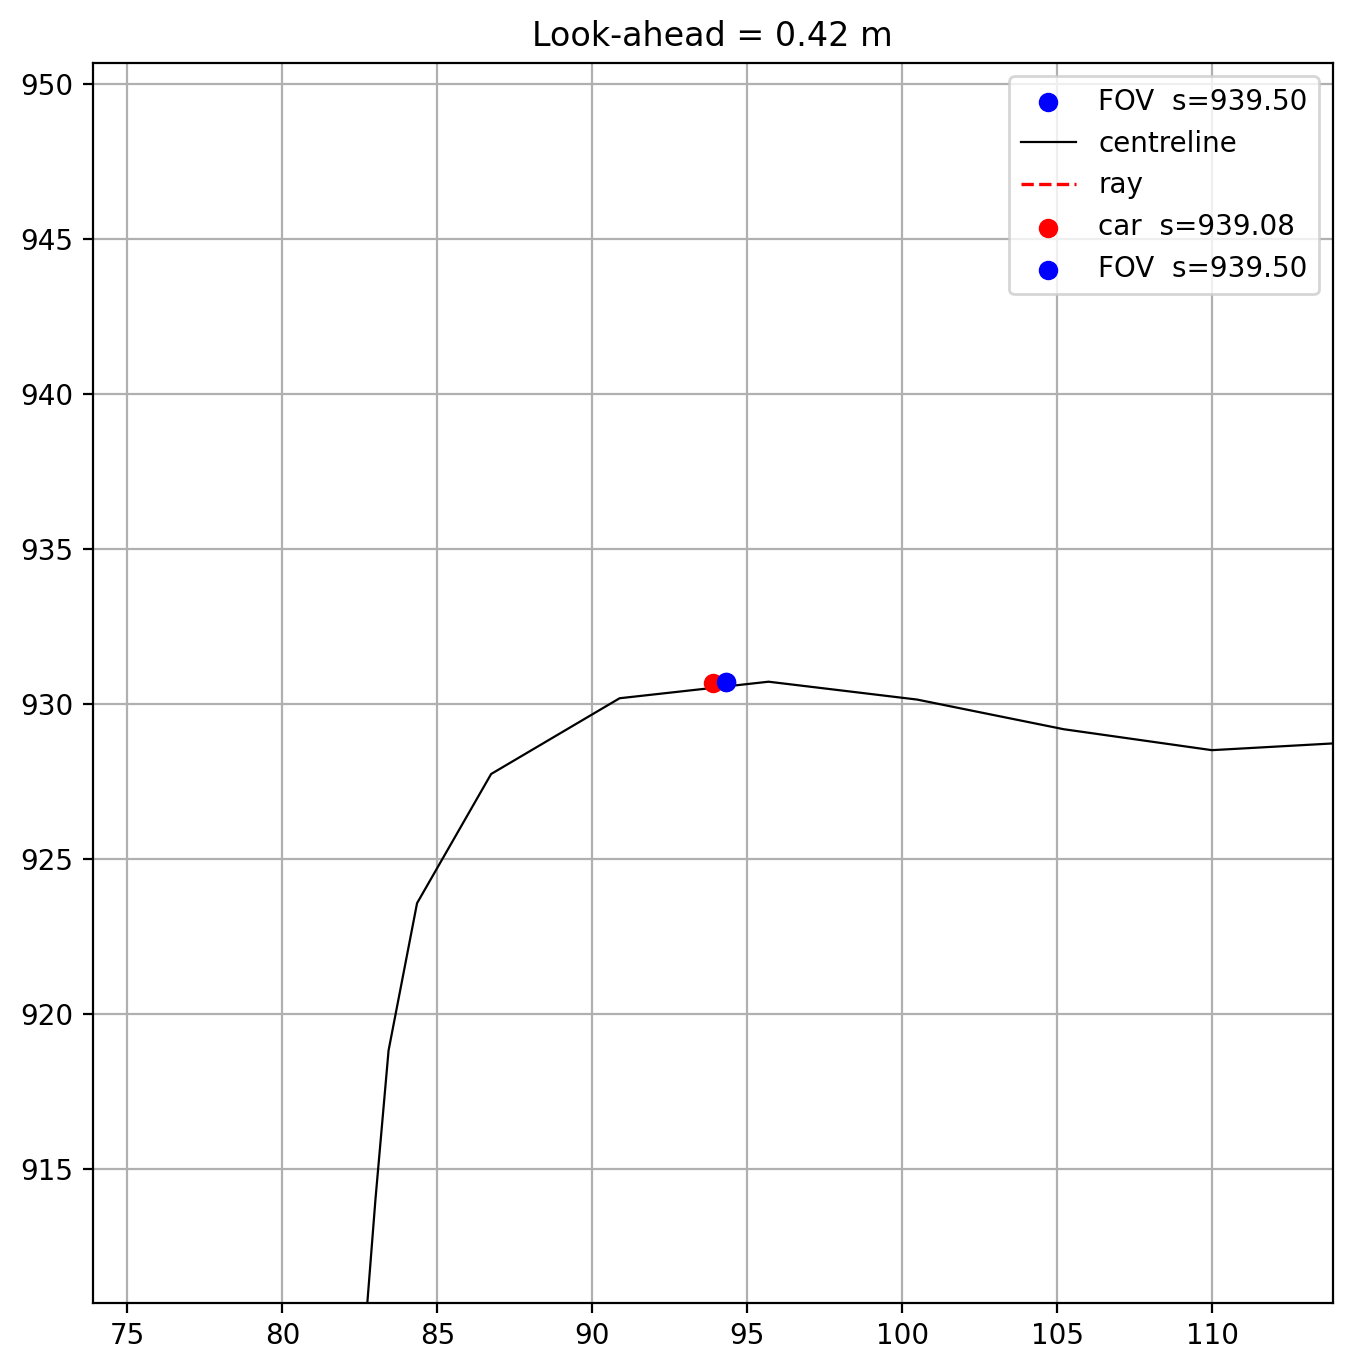

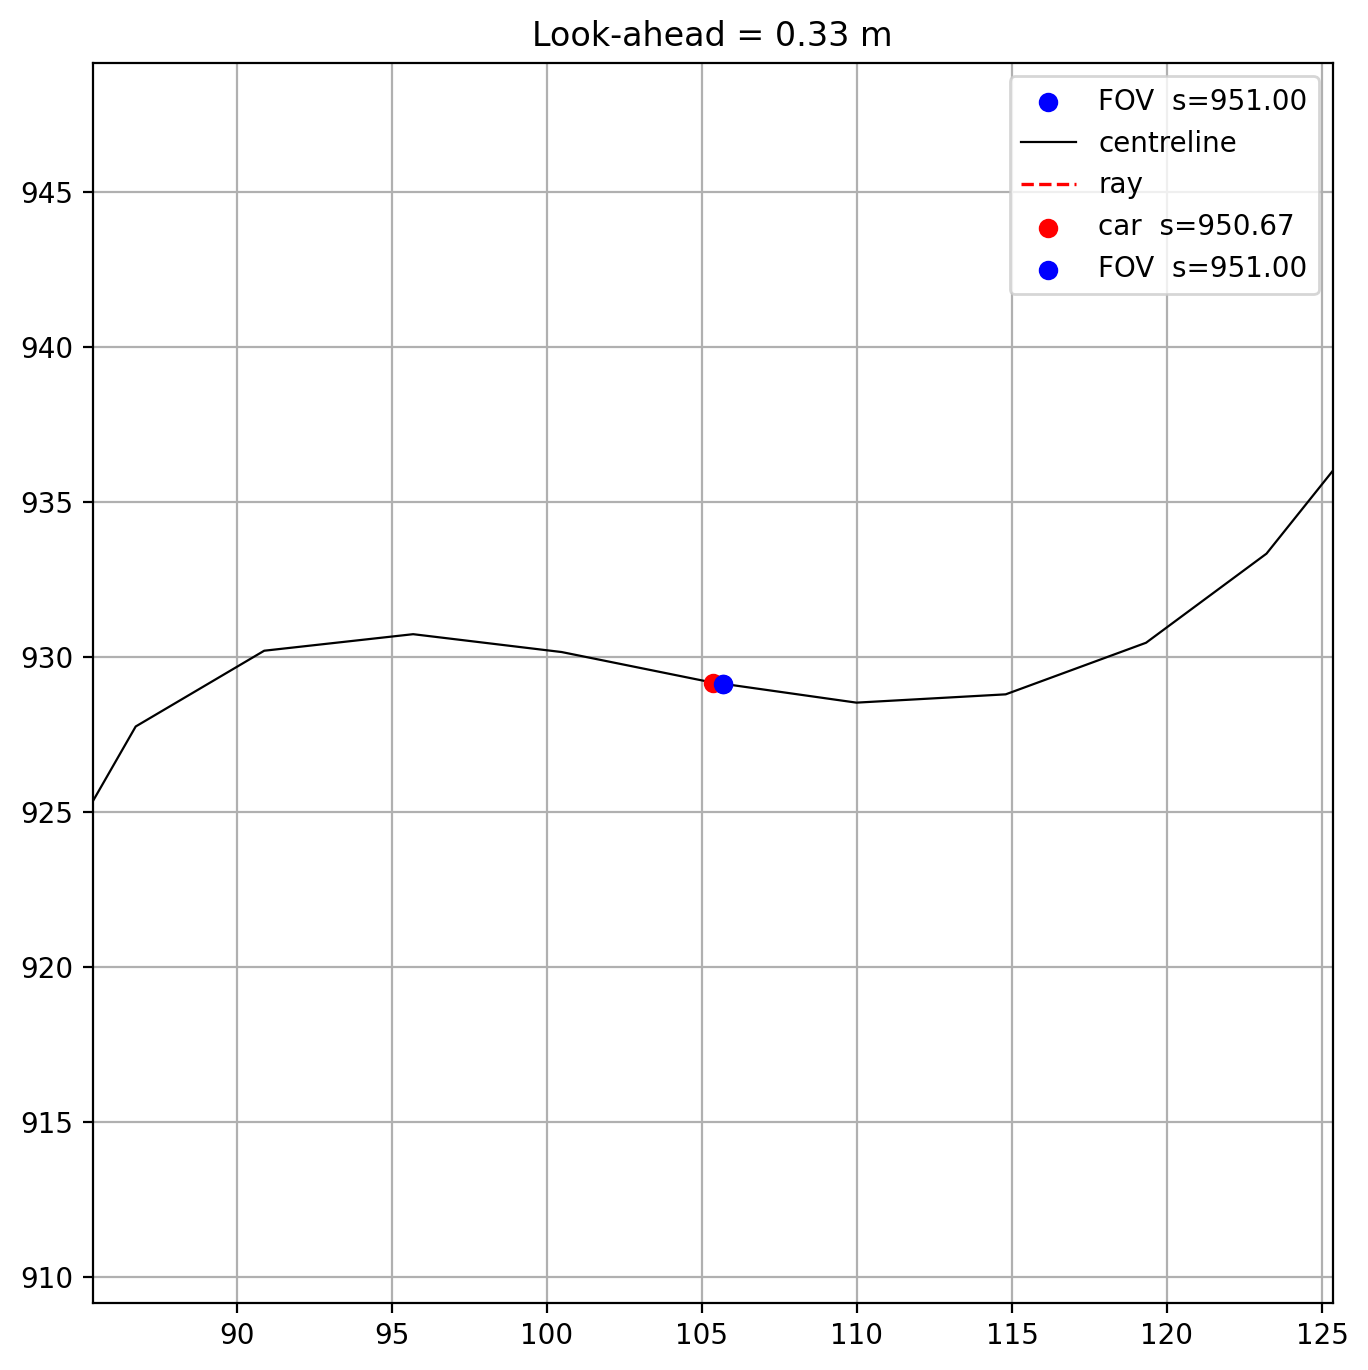

In [12]:
# ----------------------------------------------
# Visualise suspect look-ahead samples (< 2 m)
# ----------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

span = 40

# --------- 1. 找出异常样本 ---------------------
look_ahead = sfov_vals - s_query
suspect_idx = np.where(look_ahead < 2.0)[0]      # <—— 阈值可调
print("suspect s:", s_query[suspect_idx])

# 只挑前两个来画；你也可以手动指定 idx_list
idx_list = suspect_idx[:2]

# --------- 2. 预备背景（中心线 & 可选边界） -----
s_bg  = np.linspace(0, s_max, 1200)
x_bg  = x_spline(s_bg)
y_bg  = y_spline(s_bg)

# 若想同时画左右边界，取消下方注释
# w_left_bg  = np.interp(s_bg, s, w_left)
# w_right_bg = np.interp(s_bg, s, w_right)
# dx_bg = x_spline.derivative(1)(s_bg); dy_bg = y_spline.derivative(1)(s_bg)
# norm = np.hypot(dx_bg, dy_bg)
# nx_bg, ny_bg = -dy_bg / norm, dx_bg / norm
# xl_bg = x_bg + nx_bg * w_left_bg;  yl_bg = y_bg + ny_bg * w_left_bg
# xr_bg = x_bg - nx_bg * w_right_bg; yr_bg = y_bg - ny_bg * w_right_bg

for idx in idx_list:
    s0     = s_query[idx]
    s_fov  = sfov_vals[idx]

    # 车辆位置 / FOV 交点
    car_xy = np.array([x_spline(s0),     y_spline(s0)])
    fov_xy = np.array([x_spline(s_fov),  y_spline(s_fov)])

    # 车辆当前射线方向（只是用两个点连线即可）
    ray_vec = fov_xy - car_xy

    # --------- 3. 画图 -------------------------
    plt.figure(figsize=(8, 10), dpi=200)   # figsize 单位英寸, dpi 越大像素越多

    plt.scatter(*fov_xy, c='b', zorder=5, label=f'FOV  s={s_fov:.2f}')

    # ⬇⬇ 关键：限制坐标轴到车辆 ±span/2 ⬇⬇
    plt.xlim(car_xy[0] - span/2, car_xy[0] + span/2)
    plt.ylim(car_xy[1] - span/2, car_xy[1] + span/2)

    plt.gca().set_aspect('equal')


    plt.plot(x_bg, y_bg, 'k', lw=0.8, label='centreline')

    # 如需边界，取消注释
    # plt.plot(xl_bg, yl_bg, '0.7', lw=0.5)
    # plt.plot(xr_bg, yr_bg, '0.7', lw=0.5)

    plt.plot([car_xy[0], fov_xy[0]], [car_xy[1], fov_xy[1]],
             'r--', lw=1.2, label='ray')
    plt.scatter(*car_xy, c='r', zorder=5, label=f'car  s={s0:.2f}')
    plt.scatter(*fov_xy, c='b', zorder=5, label=f'FOV  s={s_fov:.2f}')

    plt.gca().set_aspect('equal')
    plt.title(f'Look-ahead = {s_fov - s0:.2f} m')
    plt.legend()
    plt.grid(True)
    plt.show()